In [58]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 
import glob as glob
import random
from statistics import mode
from numpy import trapz
from astropy.time import Time
from bs4 import BeautifulSoup
from astroquery.ned import Ned
import urllib
import urllib.request
import urllib.response
c = 299792 #speed of light in km/s

ModuleNotFoundError: No module named 'astroquery'

In [59]:
def gsmooth(x_array, y_array, var_y, vexp = .001, nsig = 5.0):
    #returns smoothed flux array
    # if no variance array create a constant one
    if len(var_y) == 0:
        var_y = np.zeros(len(y_array))
        
    for i in range(len(var_y)):
        if var_y[i] == 0:
            var_y[i] = 1E-20
            # var_y[i] = 1E-31
    
    # Output y-array
    new_y = np.zeros(len(x_array), float)
    
    # Loop over y-array elements
    for i in range(len(x_array)):
        
        # Construct a Gaussian of sigma = vexp*x_array[i]
        gaussian = np.zeros(len(x_array), float)
        sigma = vexp*x_array[i]
        
        # Restrict range to +/- nsig sigma
        sigrange = np.nonzero(abs(x_array-x_array[i]) <= nsig*sigma)
        gaussian[sigrange] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x_array[sigrange]-x_array[i])/sigma)**2)
        
        # Multiply Gaussian by 1 / variance
        W_lambda = gaussian / var_y
        
        # Perform a weighted sum to give smoothed y value at x_array[i]
        W0 = np.sum(W_lambda)
        W1 = np.sum(W_lambda*y_array)
        new_y[i] = W1/W0

    # Return smoothed y-array
    return new_y

In [60]:
def autosmooth(x_array, y_array, var_y):
    new_y_init = gsmooth(x_array, y_array, var_y, .001)
    SNR = np.mean(new_y_init / flux_error)
    
    if SNR < 5:
        vexp_auto = .0025 #temp value, need to fine tune using SNR in excel spreadsheet
    elif 5 <= SNR < 20:
        vexp_auto = .002
    elif 20 <= SNR < 40:
        vexp_auto = .0015
    elif 40 <= SNR < 60:
        vexp_auto = .001
    elif 60 <= SNR < 100:
        vexp_auto = .00075
    else:
        vexp_auto = .0005
    
    new_y = gsmooth(x_array, y_array, var_y, vexp_auto)
    return new_y

In [61]:
def deredshift(wavelength, z):
    dered_wave = wavelength / (1+z)
    return dered_wave

In [62]:
def find_min_wave(dered_wave, sm_flux, w1 = 5900., w2 = 6500.):
    elem_range = np.where((dered_wave > w1) & (dered_wave < w2)) #set domain as within minwave and maxwave
    list(elem_range)
    elem_wavelist = dered_wave[elem_range] 
    elem_fluxlist = sm_flux[elem_range] #find corresponding flux vales for wavelengths within domain
    elem_flux = min(elem_fluxlist) #find minimum value within these flux vales to locate "dip"
    elem_wavelength = dered_wave[np.where(sm_flux == elem_flux)][0] #find the corresponding wavelength
    return(elem_wavelength)

In [63]:
def find_max_wave(dered_wave, sm_flux, w1, w2):
    max_wave = np.where((dered_wave > w1) & (dered_wave < w2))
    list(max_wave)
    elem_wavelist = dered_wave[max_wave]
    elem_fluxlist = sm_flux[max_wave]
    elem_flux = max(elem_fluxlist)
    max_wave = dered_wave[np.where(sm_flux == elem_flux)][0]
    return(max_wave)

In [64]:
def find_equivalent_width(dered_wave, flux, max_1_wave, max_2_wave):
    
    eqw_domain = np.where((dered_wave >= max_1_wave) & (dered_wave <= max_2_wave))
    list(eqw_domain)
    elem_fluxlist_eqw_domain = flux[eqw_domain]
    elem_wavelist_eqw_domain = dered_wave[eqw_domain]
    line_elem = np.polyfit([max_1_wave, max_2_wave], [sm_flux[np.where(dered_wave == max_1_wave)], sm_flux[np.where(dered_wave == max_2_wave)]],1)
    line = line_elem[0]*elem_wavelist_eqw_domain + line_elem[1]
    norm = elem_fluxlist_eqw_domain/line
    equivalent_width = trapz(norm*(-1),x=elem_wavelist_eqw_domain)*(-1)
    return (equivalent_width)

In [118]:
def find_velocity(min_wave, rest_wave = 6355):
    c = 299792 #speed of light in km/s
    wavelength_prop = min_wave / rest_wave
    ejecta_velocity = c * (wavelength_prop ** 2 - 1) / (wavelength_prop ** 2 + 1)
    return ejecta_velocity

In [87]:
def get_SN_name(file):
    SN_name = file.split('-')[0]
    return SN_name

In [88]:
def make_z_dict(file):
    #reads in CfA4_info.txt
    sn_datatext = open(file, "r")
    sn_datainfo = sn_datatext.readlines()
    z_dict = {}
    start_line = 60
    for line in sn_datainfo[start_line:]:
        line_elems = line.split()
        temp = line_elems[0]
        if temp[0] == "2":
            name = "sn" + temp
        else:
            name = temp
        z = line_elems[10]
        z_dict[name] = float(z)
    return z_dict

In [89]:
def vel_error_dist(wavelength, flux, flux_error, n = 1000):
    velocity_distribution = []
    minwave = 6000
    maxwave = 7000
    wavelength_rest = 6355
    for i in range(n):
        vexp= np.random.normal(.0015,.00025) 
        smooth_flux = autosmooth(wavelength, flux, flux_error,vexp)
        SiII_obs = find_wave_obs(wavelength, smooth_flux, minwave, maxwave)
        v = find_velocity(SiII_obs, wavelength_rest)
        #print (v, vexp, SiII_obs) this line can be uncommented to analyze increments of the loop individually
        velocity_distribution.append(v)
    vmode = mode(velocity_distribution)
    vmean = np.mean(velocity_distribution)
    vstd = np.std(velocity_distribution)
    lower95bound = sorted(velocity_distribution)[24]
    upper95bound = sorted(velocity_distribution)[974]
    plt.hist(velocity_distribution)
    return "Ejecta velocity is", vmode ,"km/s", "mean velocity is", vmean, "km/s", "standard deviation is", vstd, "km/s.", "The 95th percentile confidence interval is between", lower95, "and", upper95

In [90]:
def dflux(wave):
    unsmflux = flux[np.where(dered_wavelength == wave)]
    smflux = sm_flux[np.where(dered_wavelength == wave)]
    dflux = smflux - unsmflux
    return dflux

In [91]:
#Parse ned for associated galaxy
#use astroquery to find z value
def find_z(SN_name):
    if SN_name == "sn2007if":
        z = 0.0742
    elif SN_name == "sn2007kf":
        z = 0.0460
    elif SN_name == "sn2007kg":
        z = .0070
    elif SN_name == "sn2007kh":
        z = 0.0500
    elif SN_name == "sn2008cf":
        z = 0.0460
    elif SN_name == "sn2008hm":
        z = 0.0197
    elif SN_name == "sn2009lf":
        z = 0.0450
    elif SN_name == "snf20080522000":
        z = 0.0472
    elif SN_name == "snf20080522011":
        z = 0.0397
    elif SN_name == "PTF10bjs":
        z = 0.0300
    
    #add z_dict lookup
    elif SN_name in z_dict:
        z = z_dict[SN_name]
    
    else:
        query_url = 'https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=sn2007fs&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES'
        sn_url = query_url.replace("sn2007fs", SN_name)
        response = urllib.request.urlopen(sn_url)
        ned_html = response.read()
        soup = BeautifulSoup(ned_html, 'html.parser')
        ned_text = soup.get_text().split('\n')
        for i in range(len(ned_text)):
            if 'CROSS-IDENTIFICATIONS' in ned_text[i]:
                break
        cross_id_text = ned_text[i:i+5]
        for line in cross_id_text:
            if ':' in line:
                cut1 = line.split('SN')
                for el in cut1:
                    if ':' in el:
                        galaxy = el.split(':')[0].strip()
                        data = Ned.get_table(galaxy, table = 'redshifts')
                        tablelength = len(data)
                        z = data[0][4]
    return z

In [92]:
name = get_SN_name("sn2002hu-20021113.25-fast.flm")
z = find_z(name)
print (z)

NameError: name 'urllib' is not defined

In [93]:
def find_galaxy(SN_name):
    query_url = 'https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=sn2007fs&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES'
    sn_url = query_url.replace("sn2007fs", SN_name)
    response = urllib.request.urlopen(sn_url)
    ned_html = response.read()
    soup = BeautifulSoup(ned_html, 'html.parser')
    ned_text = soup.get_text().split('\n')
    for i in range(len(ned_text)):
        if 'CROSS-IDENTIFICATIONS' in ned_text[i]:
            break
    cross_id_text = ned_text[i:i+5]
    for line in cross_id_text:
        if ':' in line:
            cut1 = line.split('SN')
            for el in cut1:
                if ':' in el:
                    galaxy = el.split(':')[0].strip()
    return galaxy

In [94]:
def plotspectra(wavelength, flux, dered_wave, sm_flux):
    plt.figure(figsize=(20, 10))
    plt.axvline(x=6355, linewidth=.5)
    #resting wavelength of Si II
    plt.plot(wavelength, flux, linewidth=1, color='red') #redshifted
    plt.plot(dered_wave, sm_flux, linewidth=1, color='blue') #deredshifted
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Relative Flux')

5914.535055714427
6343.60516714328


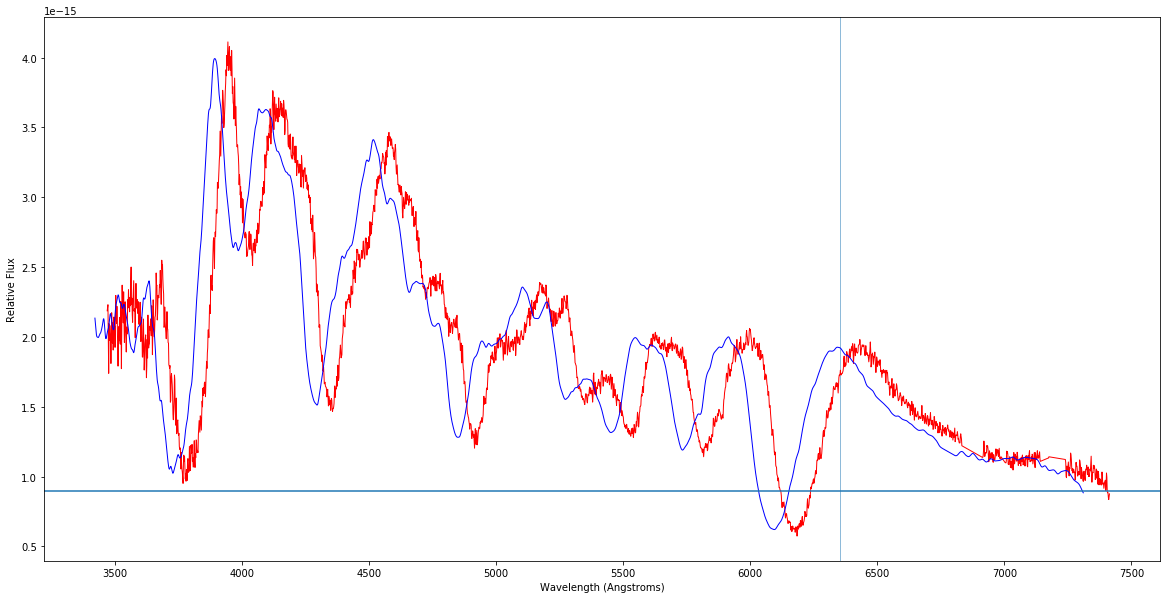

In [119]:
#TEST YOUR CODE ON ONE OBJECT (plot original spectrum, deredshifted spectrum, and the smoothed deredshifted spectrum, print velocity)
#YOUR CODE GOES HERE
file = ("sn2007hj-20070903.28-fast.flm")
my_Supernova = (file)

wavelength, flux, flux_error = np.loadtxt(my_Supernova, unpack = True)
name = get_SN_name(file)
z = find_z(name)
dered_wave = deredshift(wavelength, z)
sm_flux = autosmooth(dered_wave, flux, flux_error)

max_1_wave = find_max_wave(dered_wave,sm_flux, 5700, 6100)
print (max_1_wave)
max_2_wave = find_max_wave(dered_wave,sm_flux,6300, 6550)
print (max_2_wave)

plotspectra(wavelength, flux, dered_wave, sm_flux)

plt.axhline(y = 9e-16)


In [127]:
#YOUR CODE GOES HERE
z_dict = make_z_dict("CfA4_info.txt")
sndata = glob.glob("*.flm")

print (sndata)
print ()

index = 8

wavelength, flux, flux_error = np.loadtxt(sndata[index], unpack = True)


name = get_SN_name(sndata[index])
print ("SN name is " + name)
#z = find_z(name)
z = 0.031
print ("z value is " + str(z))


dered_wave = deredshift(wavelength, z)
sm_flux = autosmooth(dered_wave, flux, flux_error)
min_wave = find_min_wave(dered_wave, sm_flux)
print ("min_wave is " + str(min_wave))
v = find_velocity(min_wave)
print("ejecta velocity is " + str(v))

['sn1994D-19940321.35-fast.flm', 'sn1994T-19940612.19-fast.flm', 'sn1996X-19960417.33-fast.flm', 'sn1998ef-19981029.31-fast.flm', 'sn2001ex-20011018.51-fast.flm', 'sn2002hu-20021113.25-fast.flm', 'sn2003cg-20030331.21-fast.flm', 'sn2003it-20031022.26-fast.flm', 'sn2003kc-20031203.49-fast.flm', 'sn2004at-20040328.20-fast.flm', 'sn2004gs-20041215.48-fast.flm', 'sn2005A-20050107.25-fast.flm', 'sn2005eu-20051011.37-fast.flm', 'sn2006bt-20060502.33-fast.flm', 'sn2006oa-20061127.10-fast.flm', 'sn2007af-20070314.44-fast.flm', 'sn2007ba-20070409.43-fast.flm', 'sn2007bm-20070511.16-fast.flm', 'sn2007fs-20070718.42-fast.flm', 'sn2007hj-20070903.28-fast.flm', 'sn2007jg-20070920.46-fast.flm', 'sn2007kk-20071008.41-fast.flm', 'sn2007S-20070212.33-fast.flm']

SN name is sn2003kc
z value is 0.031
min_wave is 6107.6624636275465
ejecta velocity is -11894.8291607024


make_z_dict("CfA4_info.txt")

In [ ]:
class supernova:
    def __init__(self, name, spectra, z):#, spectra):
        self.name = name
        self.spectra = spectra
        self.z = z
        #self.galaxy = find_galaxy(self.name)


In [ ]:
glob.glob("CfA4_info.txt")[0]

In [ ]:
#get list of all supernovae #does not include new files from cfa_test_spectra
SN_list = []
file = glob.glob("CfA4_info.txt")[0]
sn_datatext = open(file, "r")
sn_datainfo = sn_datatext.readlines()
start_line = 60
for line in sn_datainfo[start_line:]:
    line_elems = line.split()
    temp = line_elems[0]
    if temp[0] == "2":
        name = "sn" + temp
    else:
        name = temp
    SN_list.append(name)
    
#create array of all objects with fields of supernova class populated
SN_list = []
spectra_list = []
z_list = []

for SN in SN_list:
    associated_spectra = glob.glob(SN + "*")
    associated_z = find_z(SN)
    
    spectra_list.append(associated_spectra)
    z_list.append(associated_z)
    #object = supernova(SN, associated_spectra, associated_z)
    #class_data.append((SN, associated_spectra, associated_z))
    #print(associated_spectra) #need data for spectra in CfA4_info.txt
    #print(associated_z)
    
for a in range(0, len(SN_list)):
    object = supernova(SN_list[a], spectra_list[a], z_list[a])

In [ ]:
class spectrum:
    def __init__(self, filename):
        self.filename = filename
        self.wavelength, self.flux, self.flux_error = np.loadtxt(self.filename, unpack = True)
        
    def cderedshift(self):
        z = find_z(self.name) #change to self.z?
        dered_wave = deredshift(self.wavelength, z)
        return dered_wave
        
    def cfind_min_wave(self):
        z = find_z(self.name)
        dered_wave = deredshift(self.wavelength, z)
        sm_flux = autosmooth(dered_wave, self.flux, self.flux_error) #automated smoothing has not been implemented yet
        min_wave = find_min_wave(dered_wave, sm_flux)
        return min_wave
    
    def cfind_velocity(self):
        z = find_z(self.name)
        dered_wave = deredshift(self.wavelength, z)
        sm_flux = autosmooth(dered_wave, self.flux, self.flux_error) #automated smoothing has not been implemented yet
        min_wave = find_min_wave(dered_wave, sm_flux)
        ejecta_velocity = find_velocity(min_wave)
        return ejecta_velocity
    
    def cfind_eq_width(self):
        z = find_z(self.name)
        dered_wave = deredshift(self.wavelength, z)
        sm_flux = autosmooth(dered_wave, self.flux, self.flux_error) #automated smoothing has not been implemented yet
        min_wave = find_min_wave(dered_wave, sm_flux)
        max_wave_1 = find_max_wave(dered_wave,sm_flux, min_wave - 300, min_wave - 100)
        max_wave_2 = find_max_wave(dered_wave,sm_flux, min_wave +100, min_wave +300)
        find_eq_width (dered_wave, flux, max_1_wave, max_2_wave)
        return eq_width

In [76]:
spectra = glob.glob("*.flm")
for sn_spectrum in spectra:
    a = spectrum(sn_spectrum)

In [77]:
#ERROR for some reason glob is reading in 'filename' as a file object or a variable and not a filename :/
"""class spectrum:
    def __init__(self, filename):
        self.filename = filename
        self.data = glob.glob(self.filename)
        wavelength, flux, flux_error = np.loadtxt(self.data[0], unpack = True)
        
    def csndata(self):
        sndata = glob.glob(self.filename)
        wavelength, flux, flux_error = np.loadtxt(sndata[0], unpack = True)
        plt.figure(figsize=(10, 4))
        plt.plot(wavelength,flux, linewidth=.5, color='blue')
        plt.axvline(x=6355, linewidth=.5)
        #resting wavelength of Si II
        plt.xlabel('Wavelength (Angstroms)')
        plt.ylabel('Relative Flux')
        return wavelength, flux, flux_error
    
    def cderedshift(self):
        #z = get_z(name) must be implemented later
        sndata = glob.glob(self.filename)
        wavelength, flux, flux_error = np.loadtxt(sndata[0], unpack = True)
        dered_wave = deredshift(wavelength, z)
        return dered_wave
    
    def cfind_min_wave(self):
        #z = get_z(name) must be implemented later
        z = .017193 #test
        sndata = glob.glob(self.filename)
        wavelength, flux, flux_error = np.loadtxt(sndata[0], unpack = True)
        dered_wave = deredshift(wavelength, z)
        sm_flux = gsmooth(dered_wave, flux, flux_error) #automated smoothing has not been implemented yet
        min_wave = find_min_wave(dered_wave, sm_flux)
        return min_wave
    
    def cfind_velocity(self):
        z = .017193 #test
        sndata = glob.glob(self.filename)
        wavelength, flux, flux_error = np.loadtxt(sndata[0], unpack = True)
        dered_wave = deredshift(wavelength, z)
        sm_flux = gsmooth(dered_wave, flux, flux_error) #automated smoothing has not been implemented yet
        min_wave = find_min_wave(dered_wave, sm_flux)
        ejecta_velocity = find_velocity(min_wave)
        return ejecta_velocity
"""

"class spectrum:\n    def __init__(self, filename):\n        self.filename = filename\n        self.data = glob.glob(self.filename)\n        wavelength, flux, flux_error = np.loadtxt(self.data[0], unpack = True)\n        \n    def csndata(self):\n        sndata = glob.glob(self.filename)\n        wavelength, flux, flux_error = np.loadtxt(sndata[0], unpack = True)\n        plt.figure(figsize=(10, 4))\n        plt.plot(wavelength,flux, linewidth=.5, color='blue')\n        plt.axvline(x=6355, linewidth=.5)\n        #resting wavelength of Si II\n        plt.xlabel('Wavelength (Angstroms)')\n        plt.ylabel('Relative Flux')\n        return wavelength, flux, flux_error\n    \n    def cderedshift(self):\n        #z = get_z(name) must be implemented later\n        sndata = glob.glob(self.filename)\n        wavelength, flux, flux_error = np.loadtxt(sndata[0], unpack = True)\n        dered_wave = deredshift(wavelength, z)\n        return dered_wave\n    \n    def cfind_min_wave(self):\n      

In [78]:
#FINAL SCRIPT STEPS
#1) Get array of all flm file names
#2) Make redshift dictionary
#3) loop through files
    #a) read in spectrum
    #b) get SN name from file name
    #c) get redshift from dictionary
    #d) deredshift
    #e) smooth
    #f) find wavelength where Si line is minimum
    #g) find and print velocity (and SN name)

In [79]:
sndata = glob.glob("*.flm")

z_dict = make_z_dict("CfA4_info.txt") #does not include files from cfa_test_spectra
for i in range(len(sndata)):
    name = get_SN_name(sndata[i])
    wavelength, flux, flux_error = np.loadtxt(sndata[i], unpack = True)
    dered_wave = deredshift(wavelength, find_z(name))
    sm_flux = autosmooth(dered_wave, flux, flux_error)
    min_wave = find_min_wave(dered_wave, sm_flux)
    v = find_velocity(min_wave)
    print (v)

NameError: name 'urllib' is not defined

In [80]:
def find_t_obs(file): #gets observed date and time from file name and converts it to a modified julian date
    date = file.split('-')[1]
    datetime = date[0:4] + "-" + date[4:6] + "-" + date[6:]
    t = Time(datetime)
    t.format = 'mjd'    
    t_obs = t.value
    return t_obs
    
#test it out
find_t_obs("sn2007jg-20070920.46-fast.flm")

54363.00000532407

In [81]:
def measure_phase(file, t_max, z_dict): #get t_max from Matt
    t_obs = find_t_obs(file)
    z = z_dict[get_SN_name(file)]
    phase = (t_obs - t_max)/(1+z)
    return phase

#random test with random t_max, I don't know what t-max is yet
measure_phase("sn2007jg-20070920.46-fast.flm", 53000, z_dict)

1314.2416404628993

In [82]:
def find_v_0 (phase, v_obs, sigma_vobs): #computes velocity at t_max
    v = v_obs
    t = phase
    v_0 = (v + (0.285*t))/(1 - (0.0322*t))
    sigma_v_0 = ((sigma_v_obs/(1-0.0322*t))^2 + 0.22^2)^(1/2) #get sigma_vobs from the kyle's function that determines the error of a velocity measurement
    return v_0, sigma_v_0